In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from torch.optim import Adam
from torchdiffeq import odeint

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The action of the system:

\begin{equation}
S(\phi) = m \phi^2 + \lambda \phi^4
\end{equation}

In [3]:
lam = 0.4
m = - 0.9

In [4]:
def action(phi):
    return m * phi**2 + lam * phi**4

# Generate training samples using stochastic quantization

Langevin equation:

\begin{equation}
\partial_t \phi(t) = - \frac{\partial S(\phi)}{\partial \phi}|_{\phi=\phi(t)}
+ \eta(t)
\end{equation}

Discretized Langevin equation:

\begin{equation}
\phi(t+\epsilon) = \phi(t) - \epsilon \frac{\partial S(\phi)}{\partial \phi}|_{\phi=\phi(t)}
+ \sqrt{\epsilon} \tilde{\eta}(t)
\end{equation}

with $\eta$ the discrete noise field:

\begin{equation}
\langle \tilde{\eta}(t) \rangle = 0
\end{equation}

\begin{equation}
\langle \tilde{\eta}(t) \tilde{\eta}(t') \rangle = 2 \delta_{tt'}
\end{equation}

In [5]:
epsilon = 2e-4

In [6]:
# the drift term dS/dphi
def drift_term(phi):
    return 2. * m * phi + 4. * lam * phi**3

In [7]:
# Generate random noise
def eta(n):
    return torch.randn((n)) * np.sqrt(2.)

In [8]:
def update_phi(phi):
    # phi ... field value
    return phi - epsilon * drift_term(phi) + np.sqrt(epsilon) * eta(phi.shape[0])

The initial configurations are drawn from the standard normal distribution:

$$
\phi (0) \sim \mathcal{N}(\phi(0);0,1)
$$

In [9]:
# Generate initial configurations following the standard normal distribution
def generate_initial_configs(n):
    # n ... batch size
    return torch.randn((n))

In [10]:
def run_sq(batch_size, total_steps):
    phi = generate_initial_configs(batch_size)
    for i in range(total_steps):
        phi = update_phi(phi)
    return phi

# Score and Action model definitions

In [11]:
sigma = torch.tensor(25., device=device)

In [12]:
# Diffusion coefficient g(t) of the forward SDE at time t
def diff_coeff(t):
    return sigma**t

In [13]:
# Standard deviation of p_0t at time t
def p_0t_standard_deviation(t):
    return torch.sqrt( (sigma**(2. * t) - 1.) / (2. * torch.log(sigma)) )

In [14]:
# Draw samples from the prior distribution
def draw_initial_configs(n):
    # n: number of samples
    randn = torch.randn((n,1), device=device)
    t = torch.tensor((1.), device=device)
    return randn * p_0t_standard_deviation(t)

### Score model

In [15]:
# generate samples by solving the SDE
def solve_sde_score(n, eps=1e-4):
    # n: Number of samples to be generated
    # eps: step size
    network.eval()
    
    phi = draw_initial_configs(n) # Draw from the prior distribution
    for i in range(int(1./eps)):
        t = 1. - i * eps
        t_batch = torch.ones((phi.shape[0],1), device=device) * t
        score = network(phi, t_batch).detach()
        phi = phi + eps * sigma**(2*t) * score + sigma**t * np.sqrt(eps) * torch.randn_like(phi)
    return phi.detach()

In [16]:
# Factor of the dt term in the reverse ODE
def reverse_ode_score_func_score(t, phi):
    t_batch = torch.ones((phi.shape[0],1), device=device) * t
    network.eval()
    
    score = network(phi, t_batch).detach()
    sigma_t = diff_coeff(t)
    return - sigma_t**2 * score / 2.

In [17]:
# generate samples by solving the ODE
def solve_ode_score(n, t_end=1e-5):
    # n: Number of samples to be generated
    # t_end: optional parameter, to obtain a sample at an arbitrary time in the diffusion process, 
    # default is 1e-5 and not 0 for numerical stability (whyever...)
    init_config = draw_initial_configs(n) # Draw from the prior distribution
    t_points = torch.linspace(1., t_end, 40, device=device)
    solution = odeint(reverse_ode_score_func_score, init_config, 
                      t_points, options=dict(step_size=1e-3), method = 'rk4')[-1,:]
    return solution

In [18]:
# Defining the loss function for given phi_0 sampled from p_0
def loss_function_score(phi_0):
    eps = 1e-5
    t = torch.rand((phi_0.shape[0], 1), device=device) * (1. - eps) + eps #Second part for numerical stability
    lam_sqrt = p_0t_standard_deviation(t).view(phi_0.shape[0],1)
    std_normal_dist = torch.randn_like(phi_0, device=device)
    phi_t = phi_0 + lam_sqrt * std_normal_dist

    network.train()
    score = network(phi_t, t)
        
    loss = (std_normal_dist + score * lam_sqrt)**2
    return torch.mean(loss)

In [19]:
def train_score(n_epoch, training_samples, batch_size=64):
    # n_epoch: Number of training epochs
    # training_samples: The training samples
    # batch_size: Number of training samples in one training batch
    
    n_samples = training_samples.shape[0]
    for n in range(n_epoch):
        avg_loss = 0.
        num_items = 0
        rand_perm = torch.randperm(training_samples.shape[0])
        training_samples = training_samples[rand_perm]
        for i in range(n_samples//batch_size):
            training_batch = training_samples[i*batch_size:(i+1)*batch_size]
            loss = loss_function_score(training_batch.to(device))
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * batch_size
            num_items += batch_size
        scheduler.step()

### Action model

In [20]:
# generate samples by solving the SDE
def solve_sde_action(n, eps=1e-4):
    # n: Number of samples to be generated
    # eps: step size
    network.eval()
    
    phi = draw_initial_configs(n) # Draw from the prior distribution
    for i in range(int(1./eps)):
        t = 1. - i * eps
        t_batch = torch.ones((phi.shape[0],1), device=device) * t
        
        phi = phi.detach()
        phi.requires_grad = True
        action = network(phi, t_batch)
        score = torch.autograd.grad(torch.sum(action), phi)[0].detach()
        phi = phi + eps * sigma**(2*t) * score + sigma**t * np.sqrt(eps) * torch.randn_like(phi)
    return phi.detach()

In [21]:
# Factor of the dt term in the reverse ODE
def reverse_ode_score_func_action(t, phi):
    t_batch = torch.ones((phi.shape[0],1), device=device) * t
    network.eval()
    
    phi = phi.detach()
    phi.requires_grad = True
    action = network(phi, t_batch)
    score = torch.autograd.grad(torch.sum(action), phi)[0].detach()
    sigma_t = diff_coeff(t)
    return - sigma_t**2 * score / 2.

In [22]:
# generate samples by solving the ODE
def solve_ode_action(n, t_end=1e-5):
    # n: Number of samples to be generated
    # t_end: optional parameter, to obtain a sample at an arbitrary time in the diffusion process, 
    # default is 1e-5 and not 0 for numerical stability (whyever...)
    init_config = draw_initial_configs(n) # Draw from the prior distribution
    t_points = torch.linspace(1., t_end, 40, device=device)
    solution = odeint(reverse_ode_score_func_action, init_config, 
                      t_points, options=dict(step_size=1e-3), method = 'rk4')[-1,:]
    return solution

In [23]:
# Defining the loss function for given phi_0 sampled from p_0
def loss_function_action(phi_0):
    eps = 1e-5
    t = torch.rand((phi_0.shape[0], 1), device=device) * (1. - eps) + eps #Second part for numerical stability
    lam_sqrt = p_0t_standard_deviation(t).view(phi_0.shape[0],1)
    std_normal_dist = torch.randn_like(phi_0, device=device)
    phi_t = phi_0 + lam_sqrt * std_normal_dist

    network.train()
    phi_t = phi_t.detach()
    phi_t.requires_grad = True
    action = network(phi_t, t)
    score = torch.autograd.grad(torch.sum(action), phi_t, create_graph=True)[0]
        
    loss = (std_normal_dist + score * lam_sqrt)**2
    return torch.mean(loss)

In [24]:
def train_action(n_epoch, training_samples, batch_size=4):
    # n_epoch: Number of training epochs
    # training_samples: The training samples
    # batch_size: Number of training samples in one training batch
    n_samples = training_samples.shape[0]
    for n in range(n_epoch):
        avg_loss = 0.
        num_items = 0
        rand_perm = torch.randperm(training_samples.shape[0])
        training_samples = training_samples[rand_perm]
        for i in range(n_samples//batch_size):
            training_batch = training_samples[i*batch_size:(i+1)*batch_size]
            loss = loss_function_action(training_batch.to(device))
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * batch_size
            num_items += batch_size
        scheduler.step()

### Network

In [25]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.lint = nn.Linear(1,64)
        self.lin1 = nn.Linear(1,64)
        self.lin2 = nn.Linear(64,128)
        self.lin3 = nn.Linear(128,64)
        self.lin4 = nn.Linear(64,1)
        
        self.act = nn.SiLU()

    def forward(self, x, t):
        x = self.lin1(x)
        x = self.act(x)
        t = self.lint(t)
        x += self.act(t)
        x = self.lin2(x)
        x = self.act(x)
        x = self.lin3(x)
        x = self.act(x)
        x = self.lin4(x)
        return x

# Observables

In [26]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = torch.zeros([n])
    for i in range(n):
        dataset = torch.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = torch.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = torch.sqrt(variance)
    return expectation_value.numpy(), std_dev.numpy()

$$
\langle M \rangle = \langle \phi \rangle
$$

In [27]:
def magnetization_mean(samples):
    return torch.mean(samples)

$$
\chi = \langle \phi^2 \rangle - \langle |\phi| \rangle^2
$$

In [28]:
def susceptibility(samples):
    return torch.mean(samples**2) - torch.mean(samples.abs())**2

$$
U_L = 1 - \frac{\langle \phi^4 \rangle}{3\langle \phi^2 \rangle^2}
$$

In [29]:
def binder_cumulant(samples):
    return 1. - 1./3. * torch.mean(samples**4) / torch.mean(samples**2)**2

# Training data

In [30]:
training_samples = run_sq(100000,20000)[:,None]

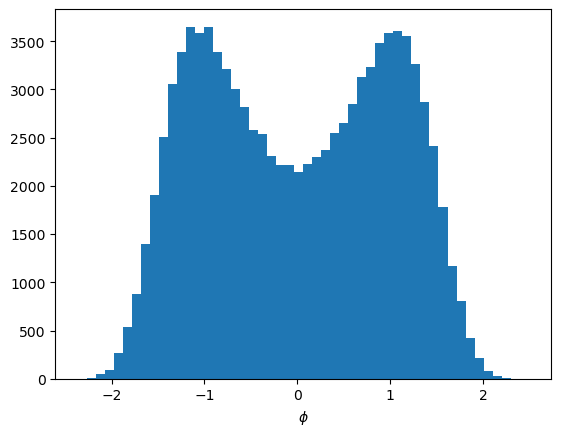

In [31]:
plt.hist(training_samples.cpu().numpy(), bins=50)
plt.xlabel(r'$\phi$')
plt.show()

In [32]:
jackknife(training_samples,magnetization_mean)

(array(-0.0005699, dtype=float32), array(0.00447608, dtype=float32))

In [33]:
jackknife(training_samples,susceptibility)

(array(0.22015816, dtype=float32), array(0.00106406, dtype=float32))

In [34]:
jackknife(training_samples,binder_cumulant)

(array(0.419645, dtype=float32), array(0.00164328, dtype=float32))

In [ ]:
#torch.save(training_samples, 'training_samples.pt')

In [ ]:
#training_samples = torch.load('training_samples.pt')

# Score Model

### Training

In [35]:
network = Network().to(device)
optimizer = Adam(network.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [36]:
train_score(1000, training_samples, batch_size=512)

In [ ]:
#torch.save({'model_state_dict': network.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict()}, r'score_network.pt')

### Results

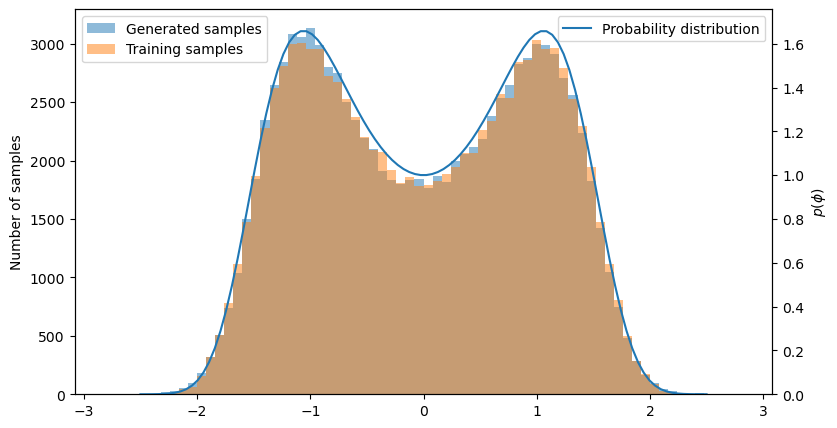

In [37]:
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.hist(solve_sde_score(100000).cpu().detach().numpy(), bins=70, range=(-2.8,2.8), alpha=0.5, label='Generated samples')
ax1.hist(training_samples[0:100000].numpy(), bins=70, range=(-2.8,2.8), alpha=0.5, label='Training samples')
ax1.legend()
ax1.set_ylabel('Number of samples')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
x_axis = np.linspace(-2.5,2.5,100)
ax2.plot(x_axis, np.exp(-action(x_axis)), label='Probability distribution')
ax2.set_ylim((0,np.exp(-action(x_axis)).max()+0.1))
ax2.legend()
ax2.legend(loc='upper right')
ax2.set_ylabel(r'$p(\phi)$')

ax2.set_xlabel(r'$\phi$')
plt.show()

In [38]:
generated_samples = solve_sde_score(10000).cpu()

In [39]:
print('Magnetization of training samples: ', 
      jackknife(training_samples, magnetization_mean)[0], 
     ' +- ', jackknife(training_samples, magnetization_mean)[1])

print('Magnetization of generated samples: ', 
      jackknife(generated_samples, magnetization_mean)[0], 
     ' +- ', jackknife(generated_samples, magnetization_mean)[1])

Magnetization of training samples:  -0.0005698993  +-  0.004476075
Magnetization of generated samples:  -0.005170636  +-  0.013961225


In [40]:
print('Susceptibility of training samples: ', 
      jackknife(training_samples, susceptibility)[0], 
     ' +- ', jackknife(training_samples, susceptibility)[1])

print('Susceptibility of generated samples: ', 
      jackknife(generated_samples, susceptibility)[0], 
     ' +- ', jackknife(generated_samples, susceptibility)[1])

Susceptibility of training samples:  0.22015816  +-  0.0010640605
Susceptibility of generated samples:  0.21812356  +-  0.003489119


In [41]:
print('Binder cumulant of training samples: ', 
      jackknife(training_samples, binder_cumulant)[0], 
     ' +- ', jackknife(training_samples, binder_cumulant)[1])

print('Binder cumulant of generated samples: ', 
      jackknife(generated_samples, binder_cumulant)[0], 
     ' +- ', jackknife(generated_samples, binder_cumulant)[1])

Binder cumulant of training samples:  0.419645  +-  0.0016432822
Binder cumulant of generated samples:  0.41438365  +-  0.005630809


# Action Model

### Training

In [42]:
network = Network().to(device)
optimizer = Adam(network.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [43]:
train_action(1000, training_samples, batch_size=512)

In [ ]:
#torch.save({'model_state_dict': network.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict()}, r'action_network.pt')

### Results

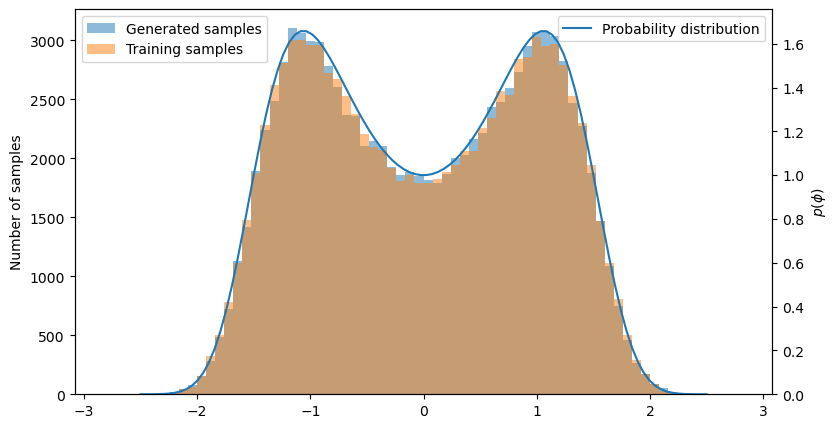

In [44]:
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.hist(solve_ode_action(100000).cpu().detach().numpy(), bins=70, range=(-2.8,2.8), alpha=0.5, label='Generated samples')
ax1.hist(training_samples[0:100000].numpy(), bins=70, range=(-2.8,2.8), alpha=0.5, label='Training samples')
ax1.legend()
ax1.set_ylabel('Number of samples')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
x_axis = np.linspace(-2.5,2.5,100)
ax2.plot(x_axis, np.exp(-action(x_axis)), label='Probability distribution')
ax2.set_ylim((0,np.exp(-action(x_axis)).max()+0.1))
ax2.legend()
ax2.legend(loc='upper right')
ax2.set_ylabel(r'$p(\phi)$')

ax2.set_xlabel(r'$\phi$')
plt.show()

In [45]:
generated_samples = solve_sde_action(10000).cpu()

In [46]:
print('Magnetization of training samples: ', 
      jackknife(training_samples, magnetization_mean)[0], 
     ' +- ', jackknife(training_samples, magnetization_mean)[1])

print('Magnetization of generated samples: ', 
      jackknife(generated_samples, magnetization_mean)[0], 
     ' +- ', jackknife(generated_samples, magnetization_mean)[1])

Magnetization of training samples:  -0.0005698993  +-  0.004476075
Magnetization of generated samples:  -0.001352658  +-  0.014267628


In [47]:
print('Susceptibility of training samples: ', 
      jackknife(training_samples, susceptibility)[0], 
     ' +- ', jackknife(training_samples, susceptibility)[1])

print('Susceptibility of generated samples: ', 
      jackknife(generated_samples, susceptibility)[0], 
     ' +- ', jackknife(generated_samples, susceptibility)[1])

Susceptibility of training samples:  0.22015816  +-  0.0010640605
Susceptibility of generated samples:  0.22167546  +-  0.0034029735


In [48]:
print('Binder cumulant of training samples: ', 
      jackknife(training_samples, binder_cumulant)[0], 
     ' +- ', jackknife(training_samples, binder_cumulant)[1])

print('Binder cumulant of generated samples: ', 
      jackknife(generated_samples, binder_cumulant)[0], 
     ' +- ', jackknife(generated_samples, binder_cumulant)[1])

Binder cumulant of training samples:  0.419645  +-  0.0016432822
Binder cumulant of generated samples:  0.4153998  +-  0.005347287


### Action as network output

In [49]:
grid_dim = 50
eff_action_grid = np.zeros((grid_dim,grid_dim))
for i in range(grid_dim):
    t = torch.ones(grid_dim,1, device=device) * i / grid_dim
    eff_action_grid[i] = - network(torch.linspace(-2,2,grid_dim,device=device)[:,None], t).detach().cpu().numpy().flatten()
    eff_action_grid[i] = eff_action_grid[i] - eff_action_grid[i,0] # Optional, fixes purely time dependent part
    
phi_axis = torch.linspace(-2,2,grid_dim).numpy()
t_axis = np.linspace(0,1,grid_dim)
phi_grid, t_grid = np.meshgrid(phi_axis, t_axis)

/tmp/ipykernel_988383/699999.py:7: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=11


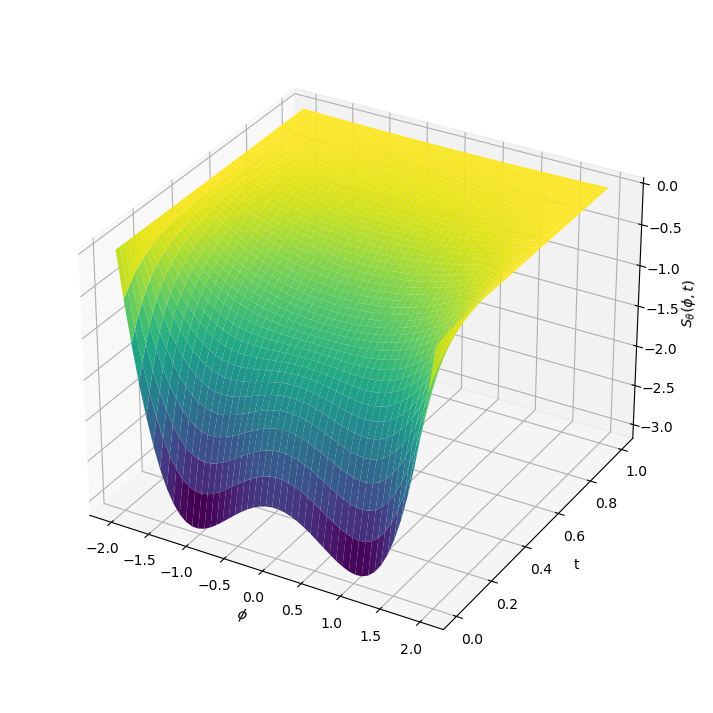

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9,9))
ax.plot_surface(phi_grid, t_grid, eff_action_grid, rstride=1, cstride=1,cmap='viridis')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel('t')
ax.set_zlabel(r'$S_{\theta}(\phi,t)$')
ax.dist=11
plt.show()

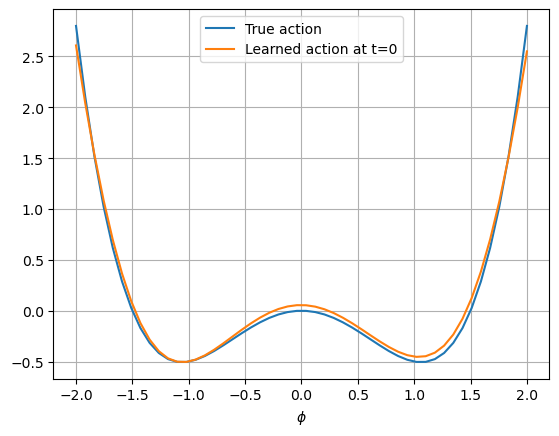

In [51]:
difference = action(torch.linspace(-2,2,grid_dim)).numpy().min() - eff_action_grid[0].min()
plt.plot(phi_axis, action(torch.linspace(-2,2,grid_dim)).numpy(), label='True action')
plt.plot(phi_axis, eff_action_grid[0]+difference, label='Learned action at t=0')
plt.legend()
plt.grid()
plt.xlabel(r'$\phi$')
plt.show()

In [52]:
def prior_log_dist(phi):
    var = (sigma**2 - 1.) / (2. * torch.log(sigma))
    dist = torch.exp(-phi**2 / (2. * var)) / torch.sqrt( 2. * np.pi * var)
    return torch.log(dist)

In [53]:
grid_dim = 100
eff_action_grid = np.zeros((grid_dim,grid_dim))
for i in range(grid_dim):
    t = torch.ones(grid_dim,1,device=device) * i / grid_dim
    eff_action_grid[i] = - network(torch.linspace(-20,20,grid_dim,device=device)[:,None], t).detach().cpu().numpy().flatten()
    eff_action_grid[i] = eff_action_grid[i] - eff_action_grid[i,0]
    
phi_axis = torch.linspace(-20,20,grid_dim).numpy()
t_axis = np.linspace(0,1,grid_dim)
phi_grid, t_grid = np.meshgrid(phi_axis, t_axis)

/tmp/ipykernel_988383/346180958.py:8: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=11


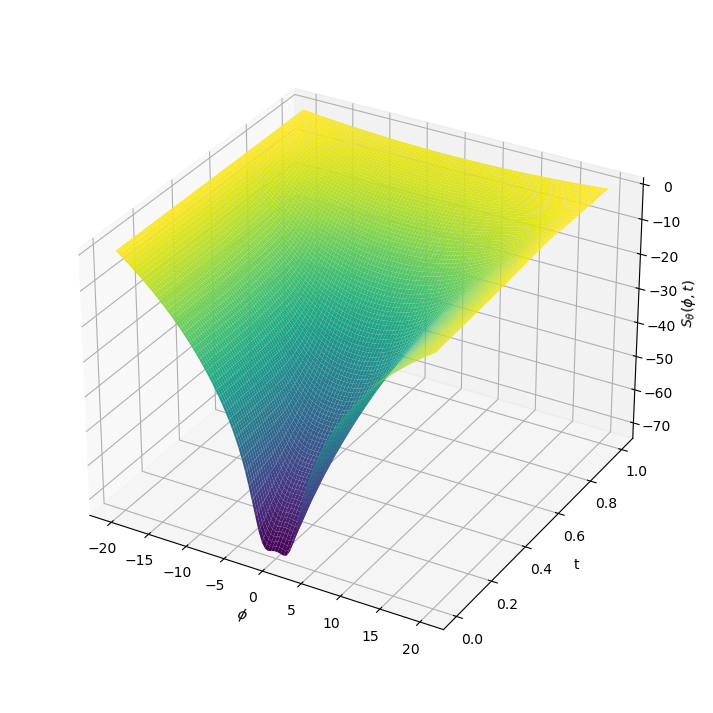

In [54]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.plot_surface(phi_grid, t_grid, eff_action_grid, rstride=1, cstride=1,cmap='viridis')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel('t')
ax.set_zlabel(r'$S_{\theta}(\phi,t)$')
ax.dist=11
plt.show()

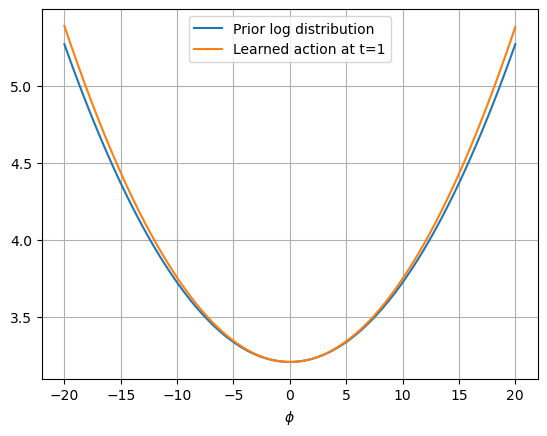

In [55]:
difference = (- prior_log_dist(torch.linspace(-20,20,grid_dim,device=device)).cpu().numpy()).min() - eff_action_grid[-1].min()

plt.plot(phi_axis, - prior_log_dist(torch.linspace(-20,20,grid_dim,device=device)).cpu().numpy(), label='Prior log distribution')
plt.plot(phi_axis, eff_action_grid[-1]+difference, label='Learned action at t=1')
plt.legend()
plt.xlabel(r'$\phi$')
plt.grid()
plt.show()